# Calculating ground states on large scale systems: Quantum Krylov Subspaces

## Step 1: Map problem to quantum native format

Given a matrix H that we are interested in, subspace methods use a set of states as a basis for the construction of a smaller representation of H, which captures its properties of interest (e.g. lowest eigenvalue).


What is the Krylov subspace? 

$$K^r = \left\{ \vert \psi \rangle, H \vert \psi \rangle, H^2 \vert \psi \rangle, ..., H^{r-1} \vert \psi \rangle \right\}$$

Is the krylov subspace for a given matrix $H$ and vector $\vert \psi \rangle$ of order $r$ where $\vert \psi \rangle$ is an aribitrary state called "reference state".

The reference state can be expanded in terms of the eigenvectors $\vert \lambda_i \rangle$ of the matrix $H$:

$$ \vert \psi \rangle = c_1 \vert \lambda_1 \rangle + c_2 \vert \lambda_2 \rangle + ... + c_n \vert \lambda_n \rangle $$

Applying $j^{th}$ power of the matrix $H$ gives:

$$ H^n \vert \psi \rangle = c_1 \lambda_1^n \vert \lambda_1 \rangle + c_2 \lambda_2^n \vert \lambda_2 \rangle + ... + c_n \lambda_n^n \vert \lambda_n \rangle $$

Which means that the component $k$ with the largest eigenvalue $\lambda_k$ is amplified by the power iteration (This can also be a problem as the basis vector become too similar to each other). The same is true for the smallest eigenvalue, if we consider power iteration of the matrix $A^{-1}$.

Why is it useful for ground state energy problems?

The Krylov subspace is constructed using the power iteration method. Therefore, states in the Krylov subspace corresponding to the multiplication with higher power of the matrix with the reference states will have the contribution of the ground state $\vert \lambda_k \rangle$ enhanced.


The Krylov subspace that we use classically cannot be accessed on a quantum computer as $H$ is not a unitary matrix. Instead, we can use the time-evolution operator $U = e^{-iHt}\sim \sum_j \frac{(-it)^j}{j!}H^j$ which is equivalent for small times $t$. Powers of $U$ then become different time steps $U^k = e^{-iH(kt)}$.


$$K_U^r = \left\{ \vert \psi \rangle, U \vert \psi \rangle, U^2 \vert \psi \rangle, ..., U^{r-1} \vert \psi \rangle \right\}$$

First, we want to find a compact represention of the Hamiltonian in the Krylov subspace $\tilde{H}$. Given that the Krylov subspace has dimension $r$, the Hamiltonian projected into the Krylov subspace will have dimensions $r \times r$. We can then easily diagonalize the projected Hamiltonian $\tilde{H}$. However, we cannot directly diagonalize $\tilde{H}$ because of the non-orthogonality of the Krylov subpace vectors. We'll have to measure theyr overlaps and construct a matrix $\tilde{S}$ collecting them to do so. We can then  solve the generalized eigenvalue problem

$$ \tilde{H} \ \vec{c} = c \ \tilde{S} \ \vec{c} $$

Where $\tilde{H}=\langle \psi_m \vert \hat{H} \vert \psi_n \rangle$ is the Hamiltonian matrix in the Krylov subspace $K_D = \left\{ \vert \psi_0 \rangle, \vert \psi_1 \rangle, ..., \vert \psi_D \rangle \right\}$ with dimension $D$, $\vec{c}$ is a vector of variational coefficients that are optimized to get the lowest value of the energy $c_{min}=E_{GS}$ and $\tilde{S}=\langle \psi_m  \vert \psi_n \rangle$ is a matrix of overlaps between states of the Krylov subspace.

Each of the Krylov subspace's vectors are obtained by time-evolving the reference state $\vert \psi_0 \rangle$ under the Hamiltonian $\hat{H}$ for a certain time: $\vert \psi_l \rangle = \hat{U} \vert \psi_0 \rangle = e^{-i \hat{H} t_l}\vert \psi_0 \rangle$. 

We can implement the algorithm on a quantum computer by using the Hadamard test to calculate the matrix elements of $\tilde{H}$ and $\tilde{S}$ as expectation values:

$$\langle \psi_m \vert \hat{H} \vert \psi_n \rangle$$
$$\langle \psi_0 \vert  e^{i \hat{H} t_m}   \hat{H} e^{-i \hat{H} t_n} \vert \psi_0 \rangle$$
$$\langle \psi_0 \vert  e^{i \hat{H} m \delta t}   \hat{H} e^{-i \hat{H} n \delta t} \vert \psi_0 \rangle$$
$$\langle \psi_0 \vert \hat{H} e^{-i \hat{H} (n-m) \delta t} \vert \psi_0 \rangle$$

### Imports and definitions



In [1]:
import math
import numpy as np
import scipy as sp
import matplotlib.pylab as plt
import warnings
warnings.filterwarnings('ignore')

from qiskit.quantum_info import SparsePauliOp, Operator
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import SuzukiTrotter, MatrixExponential
from qiskit.providers.fake_provider import FakePrague
from qiskit.primitives import Estimator

def solve_regularized_gen_eig(h, s, threshold, k=1, return_dimn=False):
    s_vals, s_vecs = sp.linalg.eigh(s)
    s_vecs = s_vecs.T
    good_vecs = np.array([vec for val, vec in zip(s_vals, s_vecs) if val > threshold])
    h_reg = good_vecs.conj() @ h @ good_vecs.T
    s_reg = good_vecs.conj() @ s @ good_vecs.T
    if k==1:
        if return_dimn:
            return sp.linalg.eigh(h_reg, s_reg)[0][0], len(good_vecs)
        else:
            return sp.linalg.eigh(h_reg, s_reg)[0][0]
    else:
        if return_dimn:
            return sp.linalg.eigh(h_reg, s_reg)[0][:k], len(good_vecs)
        else:
            return sp.linalg.eigh(h_reg, s_reg)[0][:k]

### Define Hamiltonian
Let's consider the Heisenberg Hamiltonian for $N$ qubits on a linear chain: $H=-J \sum_{i,j}^N Z_i Z_j + J \sum_{i,j}^N X_i X_j + Y_i Y_j$

In [2]:
# Define problem Hamiltonian. Kicked Ising in this case
n_qubits = 10
J = 1 # coupling strength for ZZ interaction

# Define interacting part of the Hamiltonian: sum_ij Z_i Z_j
H_int = [['I']*n_qubits for _ in range(3*(n_qubits-1))]
for i in range(n_qubits-1):
    H_int[i][i] = 'Z'
    H_int[i][i+1] = 'Z'
for i in range(n_qubits-1):
    H_int[n_qubits-1+i][i] = 'X'
    H_int[n_qubits-1+i][i+1] = 'X'
for i in range(n_qubits-1):
    H_int[2*(n_qubits-1)+i][i] = 'Y'
    H_int[2*(n_qubits-1)+i][i+1] = 'Y'
H_int = [''.join(term) for term in H_int]
H_tot = [(term, -J) if term.count('Z') == 2 else (term, 1) for term in H_int]

# Get operator
H_op = SparsePauliOp.from_list(H_tot)
H_op

SparsePauliOp(['ZZIIIIIIII', 'IZZIIIIIII', 'IIZZIIIIII', 'IIIZZIIIII', 'IIIIZZIIII', 'IIIIIZZIII', 'IIIIIIZZII', 'IIIIIIIZZI', 'IIIIIIIIZZ', 'XXIIIIIIII', 'IXXIIIIIII', 'IIXXIIIIII', 'IIIXXIIIII', 'IIIIXXIIII', 'IIIIIXXIII', 'IIIIIIXXII', 'IIIIIIIXXI', 'IIIIIIIIXX', 'YYIIIIIIII', 'IYYIIIIIII', 'IIYYIIIIII', 'IIIYYIIIII', 'IIIIYYIIII', 'IIIIIYYIII', 'IIIIIIYYII', 'IIIIIIIYYI', 'IIIIIIIIYY'],
              coeffs=[-1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j,
 -1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,
  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,
  1.+0.j,  1.+0.j,  1.+0.j])

### Set parameters for the algorithm

In [3]:
# Set parameters for quantum Krylov algorithm
krylov_dim = 20 # size of krylov subspace
dt = 0.1 # time step
num_trotter_steps = 4
dt_circ = dt/num_trotter_steps

### State preparation
Pick a reference state $\vert \psi \rangle$ that has some overlap with the ground state. For this Hamiltonian, We use the "checkerboard" state $\vert 0101...01 \rangle$ as our reference.

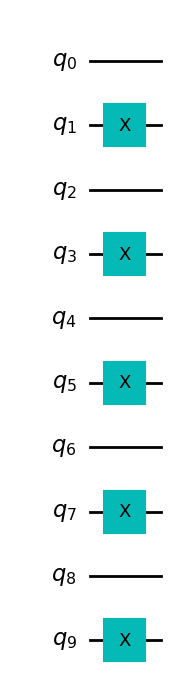

In [4]:
qc_state_prep = QuantumCircuit(n_qubits)
for i in range(n_qubits):
    if i%2 != 0:
        qc_state_prep.x(i)
qc_state_prep.draw('mpl')

### Time evolution

We can realize the time-evolution operator generated by a given Hamiltonian: $U=e^{-iHt}$

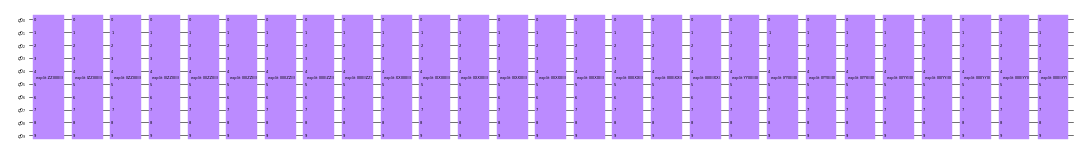

In [5]:
t = Parameter('t')

 ## Create the time-evo op circuit
evol_gate = PauliEvolutionGate(H_op, time=t, synthesis=SuzukiTrotter(order=1) )

qr = QuantumRegister(n_qubits)
qc_evol = QuantumCircuit(qr)
qc_evol.append(evol_gate, qargs=qr)

qc_evol.decompose().draw('mpl', fold=-1, scale=0.2)

### Hadamard test

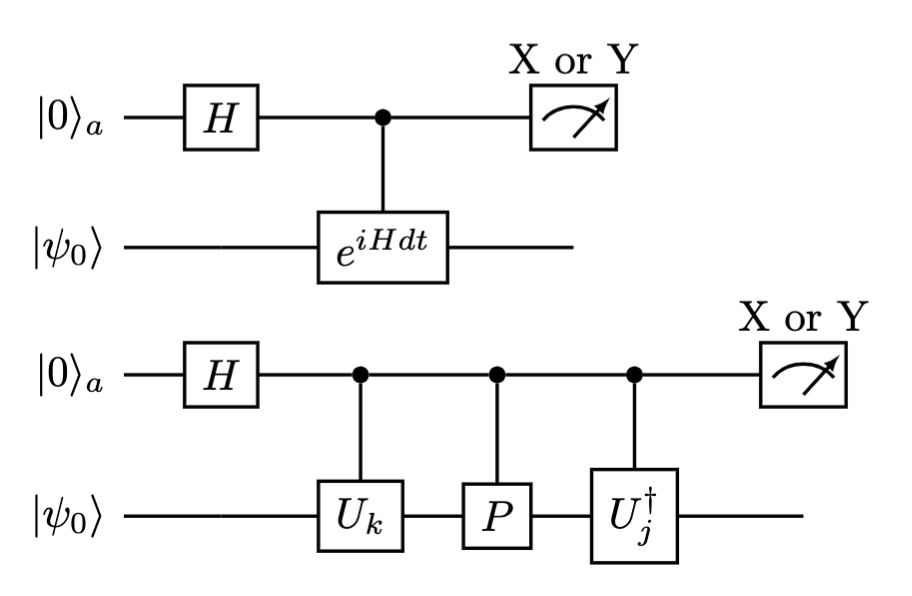


\begin{equation}
    |0\rangle_a|\psi_0\rangle\quad\longrightarrow\quad\frac{1}{\sqrt{2}}\Big(|0\rangle+|1\rangle\Big)_a|\psi_0\rangle\quad\longrightarrow\quad\frac{1}{\sqrt{2}}\Big(|0\rangle_a|\psi_0\rangle+|1\rangle_aU_j^\dagger PU_k|\psi_0\rangle\Big)
\end{equation}
To measure $X$, first apply $H$...
\begin{equation}
    \longrightarrow\quad\frac{1}{2}|0\rangle_a\Big(|\psi_0\rangle+U_j^\dagger PU_k|\psi_0\rangle\Big) + \frac{1}{2}|1\rangle_a\Big(|\psi_0\rangle-U_j^\dagger PU_k|\psi_0\rangle\Big)
\end{equation}
... then measure:
\begin{equation}
\begin{split}
    \Rightarrow\quad\langle X\rangle_a &= \frac{1}{4}\Bigg(\Big\||\psi_0\rangle+U_j^\dagger PU_k|\psi_0\rangle\Big\|^2-\Big\||\psi_0\rangle-U_j^\dagger PU_k|\psi_0\rangle\Big\|^2\Bigg) \\
    &= \text{Re}\Big[\langle\psi_0|U_j^\dagger PU_k|\psi_0\rangle\Big].
\end{split}
\end{equation}
Similarly, measuring $Y$ yields
\begin{equation}
    \langle Y\rangle_a = \text{Im}\Big[\langle\psi_0|U_j^\dagger PU_k|\psi_0\rangle\Big].
\end{equation}

Circuit for calculating the real part of the overlap in S via Hadamard test


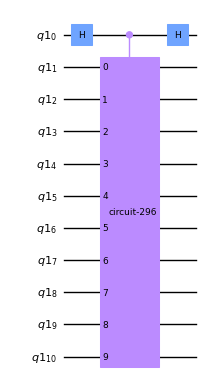

In [6]:
## Create the time-evo op circuit
evol_gate = PauliEvolutionGate(H_op, time=dt, synthesis= SuzukiTrotter(order=1) ) #MatrixExponential exact matrix exp, SuzukiTrotter(order=2) for order-2 Trotter evo op

## Create the time-evo op dagger circuit
evol_gate_d = PauliEvolutionGate(H_op, time=dt, synthesis= SuzukiTrotter(order=1) )
evol_gate_d = evol_gate_d.inverse()

# Put pieces together
qc_temp = QuantumCircuit(n_qubits)
qc_temp.compose(qc_state_prep, inplace=True)
for _ in range(num_trotter_steps):
    qc_temp.append(evol_gate, qargs=qc_temp.data[0].qubits[0].register)
for _ in range(num_trotter_steps):
    qc_temp.append(evol_gate_d, qargs=qc_temp.data[0].qubits[0].register)
qc_temp.compose(qc_state_prep.inverse(), inplace=True)

# Create controlled version of the circuit
controlled_U = qc_temp.to_gate().control(1)

# Create hadamard test circuit for real part
qr = QuantumRegister(n_qubits+1)
qc_real = QuantumCircuit(qr)
qc_real.h(0)
qc_real.append(controlled_U, list(range(n_qubits+1)))
qc_real.h(0)

print('Circuit for calculating the real part of the overlap in S via Hadamard test')
qc_real.draw('mpl', fold=-1, scale=0.5)

The Hadamard test circuit can be a deep circuit once we transpile to native gates and topology of a device. For example the 5 qubits case considered here 

In [7]:
circuit_trans = transpile(qc_real.decompose().decompose(), FakePrague())

print('The circuit has 2Q gates depth: ', circuit_trans.depth(lambda x: x[0].num_qubits ==2))


The circuit has 2Q gates depth:  8047


## Step 2: Optimize circuits and operators

We can optimize the deep circuits for the Hadamard test that we have obtained by introducing some approximations and relying on some assumption about the model Hamiltonian. For example, consider the following circuit for the Hadamard test:


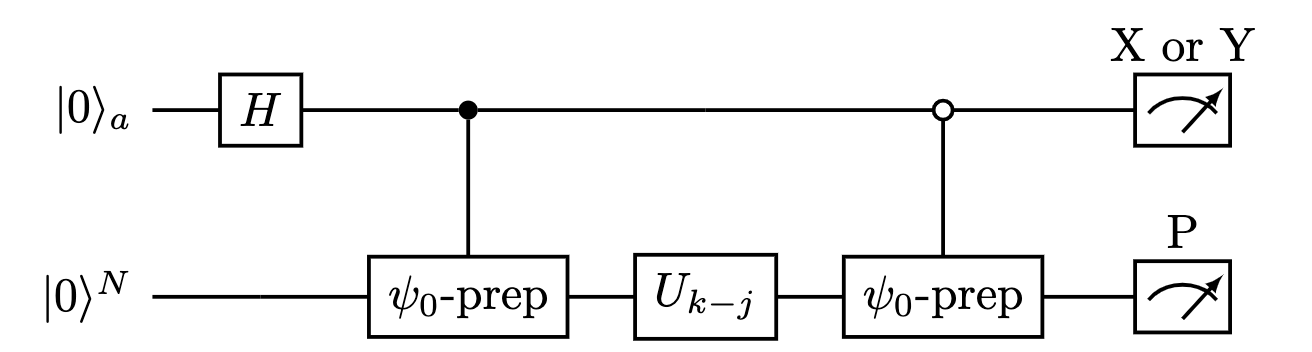

Assume we can classically calculate $E_0$, the eigenvalue of $|0\rangle^N$ under the Hamiltonian $H$.
This is satisfied when the Hamiltonian preserves the U(1) symmetry.
Assume that the gate $\psi_0-prep$ prepares our desired reference state $\ket{\psi_0}$, e.g., to prepare the HF state for chemistry $\psi_0-prep$ would be a product of single-qubit NOTs, so controlled-$\psi_0-prep$ is just a product of CNOTs.
Then the circuit above implements the following state prior to measurement:

\begin{equation}
\begin{split}
    \ket{0} \ket{0}^N\xrightarrow{H}&\frac{1}{\sqrt{2}}
    \left(
    \ket{0}\ket{0}^N+ \ket{1} \ket{0}^N
    \right)\\
    \xrightarrow{\text{1-ctrl-init}}&\frac{1}{\sqrt{2}}\left(|0\rangle|0\rangle^N+|1\rangle|\psi_0\rangle\right)\\
    \xrightarrow{U}&\frac{1}{\sqrt{2}}\left(e^{i\phi}\ket{0}\ket{0}^N+\ket{1} U\ket{\psi_0}\right)\\
    \xrightarrow{\text{0-ctrl-init}}&\frac{1}{\sqrt{2}}
    \left(
    e^{i\phi}\ket{0} \ket{\psi_0}
    +\ket{1} U\ket{\psi_0}
    \right)\\
    =&\frac{1}{2}
    \left(
    \ket{+}\left(e^{i\phi}\ket{\psi_0}+U\ket{\psi_0}\right)
    +\ket{-}\left(e^{i\phi}\ket{\psi_0}-U\ket{\psi_0}\right)
    \right)\\
    =&\frac{1}{2}
    \left(
    \ket{+i}\left(e^{i\phi}\ket{\psi_0}-iU\ket{\psi_0}\right)
    +\ket{-i}\left(e^{i\phi}\ket{\psi_0}+iU\ket{\psi_0}\right)
    \right)
\end{split}
\end{equation}

where we have used the classical simulable phase shift $ U\ket{0}^N = e^{i\phi}\ket{0}$ in the third line. Therefore the expectation values are obtained as

\begin{equation}
\begin{split}
    \langle X\otimes P\rangle&=\frac{1}{4}
    \Big(
    \left(e^{-i\phi}\bra{\psi_0}+\bra{\psi_0}U^\dagger\right)P\left(e^{i\phi}\ket{\psi_0}+U\ket{\psi_0}\right)
    \\
    &\qquad-\left(e^{-i\phi}\bra{\psi_0}-\bra{\psi_0}U^\dagger\right)P\left(e^{i\phi}\ket{\psi_0}-U\ket{\psi_0}\right)
    \Big)\\
    &=\text{Re}\left[e^{-i\phi}\bra{\psi_0}PU\ket{\psi_0}\right],
\end{split}
\end{equation}

\begin{equation}
\begin{split}
    \langle Y\otimes P\rangle&=\frac{1}{4}
    \Big(
    \left(e^{-i\phi}\bra{\psi_0}+i\bra{\psi_0}U^\dagger\right)P\left(e^{i\phi}\ket{\psi_0}-iU\ket{\psi_0}\right)
    \\
    &\qquad-\left(e^{-i\phi}\bra{\psi_0}-i\bra{\psi_0}U^\dagger\right)P\left(e^{i\phi}\ket{\psi_0}+iU\ket{\psi_0}\right)
    \Big)\\
    &=\text{Im}\left[e^{-i\phi}\bra{\psi_0}PU\ket{\psi_0}\right].
\end{split}
\end{equation}


### Decompose time-evolution operator with Suzuki-Trotter decomposition
Instead of implementing the time-evolution operator exactly we can use the Suzuki-Trotter decomposition to implement an approximation of it. Repeating several times a certain order Trotter decomposition gives us further reduction of the error introduced from the approximation.

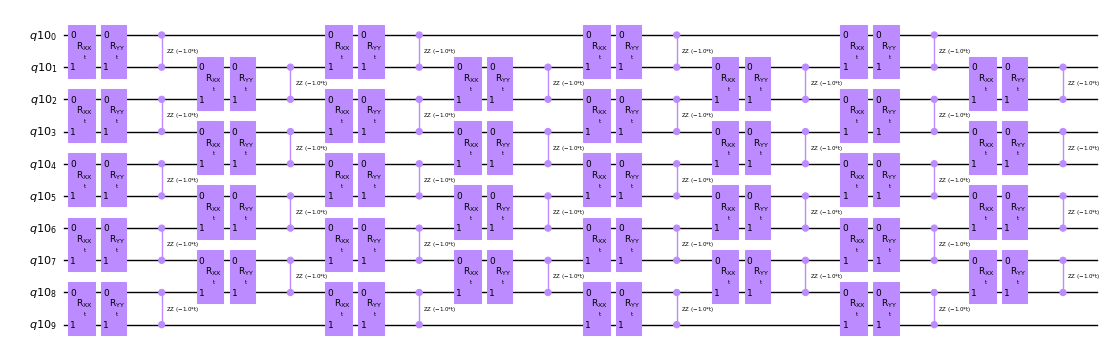

In [8]:
t = Parameter('t')

# ## Create the time-evo op circuit
# evol_gate = PauliEvolutionGate(H_op, time=t, synthesis=SuzukiTrotter(order=1)) #MatrixExponential exact matrix exp, SuzukiTrotter(order=2) for order-2 Trotter evo op

# Create instruction for rotation about XX+YY-ZZ:
Rxyz_circ = QuantumCircuit(2)
Rxyz_circ.rxx(t,0,1)
Rxyz_circ.ryy(t,0,1)
Rxyz_circ.rzz(-t,0,1)
Rxyz_instr = Rxyz_circ.to_instruction(label='RXX+YY-ZZ')

interaction_list = [[[i, i+1] for i in range(0, n_qubits-1, 2)], [[i, i+1] for i in range(1, n_qubits-1, 2)]] # linear chain

qr = QuantumRegister(n_qubits)
trotter_step_circ = QuantumCircuit(qr)
for i, color in enumerate(interaction_list):
    for interaction in color:
        trotter_step_circ.append(Rxyz_instr, interaction)


qc_evol = QuantumCircuit(qr)
for _ in range(num_trotter_steps):
    qc_evol.compose(trotter_step_circ, inplace=True)

qc_evol.decompose().draw('mpl', fold=-1, scale = 0.5)

### Use an optimized circuit for state preparation

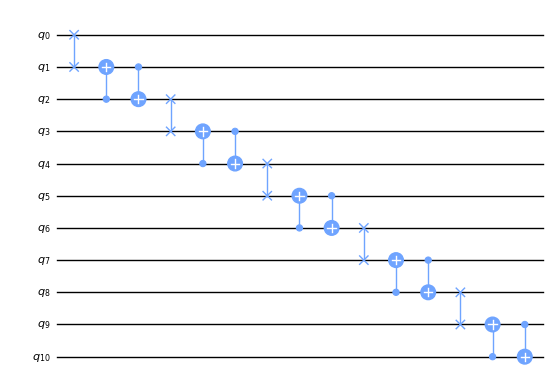

In [9]:
controlled_state_prep = QuantumCircuit(n_qubits + 1)
for idx in range(n_qubits):
    if idx % 2 == 0:
        controlled_state_prep.swap(idx, idx+1)
    else:
        controlled_state_prep.cx(idx+1, idx)
        controlled_state_prep.cx(idx, idx+1)


controlled_state_prep.draw('mpl', fold=-1, scale=0.5)

### Template circuits for calculating matrix elements of $\tilde{S}$ via Hadamard test

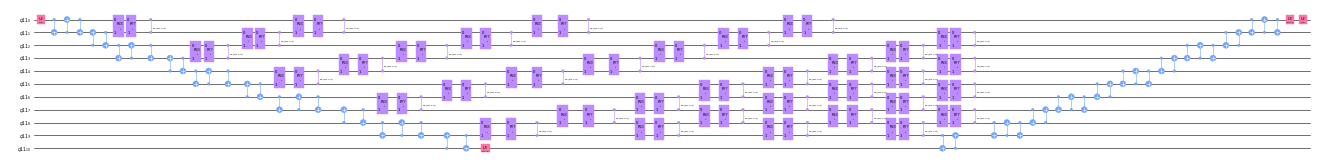

In [10]:
# Create hadamard test circuit for real part
qr = QuantumRegister(n_qubits+1)
qc_real = QuantumCircuit(qr)
qc_real.h(0)
qc_real.compose(controlled_state_prep, list(range(n_qubits+1)), inplace=True)
qc_real.x(n_qubits)
qc_real.compose(qc_evol, list(range(n_qubits)), inplace=True)
qc_real.compose(controlled_state_prep.inverse(), list(range(n_qubits+1)), inplace=True)
qc_real.x(0)
qc_real.h(0)

S_real_circ = qc_real.decompose().copy()

# # Create hadamard test circuit for imaginary part
qr = QuantumRegister(n_qubits+1)
qc_imag = QuantumCircuit(qr)
qc_imag.h(0)
qc_imag.sdg(0)
qc_imag.compose(controlled_state_prep, list(range(n_qubits+1)), inplace=True)
qc_imag.x(n_qubits)
qc_imag.compose(qc_evol, list(range(n_qubits)), inplace=True)
qc_imag.compose(controlled_state_prep.inverse(), list(range(n_qubits+1)), inplace=True)
qc_imag.x(0)
qc_imag.h(0)


S_imag_circ = qc_imag.decompose().copy()

S_real_circ.draw('mpl', fold=-1, scale = 0.2)

In [11]:
circuit_trans_opt = transpile(S_real_circ.decompose().decompose(), FakePrague())

print('The circuit has 2Q gates depth: ', circuit_trans_opt.depth(lambda x: x[0].num_qubits ==2))

The circuit has 2Q gates depth:  96


We have considerably reduced the depth of the Hadamard test with a combination of Trotter approximation and uncontrolled unitaries

### Template circuits for calculating matrix elements of $\tilde{H}$ via Hadamard test
The only difference between the circuits used in the Hadamard test will be the phase in the time-evolution operator and the observables measured. Therefore we can prepare a template circuit which represent the generic circuit for the Hadamard test, with placeholders for the gates that depend on the time-evolution operator.


In [12]:
# Hamiltonian terms to measure
observable_list = []
for idx_ket in range(krylov_dim):
    for idx_bra in range(idx_ket + 1):
        for pauli, coeff in zip(H_op.paulis, H_op.coeffs):
            # print(pauli)
            observable = pauli[::-1].to_label() + 'Z'
            observable_list.append(observable)



# Real part
# First half hadamard test
qr = QuantumRegister(n_qubits+1)
qc_real_1 = QuantumCircuit(qr)
qc_real_1.h(0)
qc_real_1.compose(controlled_state_prep, list(range(n_qubits+1)), inplace=True)
qc_real_1.x(n_qubits)
qc_real_1.compose(qc_evol, list(range(n_qubits)), inplace=True)    
H_real_circ_1 = qc_real_1.decompose().copy()

# Second half hadamard test
qr = QuantumRegister(n_qubits+1)
qc_real_2 = QuantumCircuit(qr)
qc_real_2.compose(controlled_state_prep.inverse(), list(range(n_qubits+1)), inplace=True)
qc_real_2.x(0)
qc_real_2.h(0)
H_real_circ_2 = qc_real_2.decompose().copy()

# Imaginary part
# First half hadamard test
qr = QuantumRegister(n_qubits+1)
qc_imag_1 = QuantumCircuit(qr)
qc_imag_1.h(0)
qc_imag_1.compose(controlled_state_prep, list(range(n_qubits+1)), inplace=True)
qc_imag_1.x(n_qubits)
qc_imag_1.compose(qc_evol, list(range(n_qubits)), inplace=True)    
H_imag_circ_1 = qc_imag_1.decompose().copy()

# Second half hadamard test
qr = QuantumRegister(n_qubits+1)
qc_imag_2 = QuantumCircuit(qr)
qc_imag_2.compose(controlled_state_prep.inverse(), list(range(n_qubits+1)), inplace=True)
qc_imag_2.x(0)
qc_imag_2.sdg(0)
qc_imag_2.h(0)
H_imag_circ_2 = qc_imag_2.decompose().copy()


## Step 3: Execute using a quantum primitive

Generate circuits to calculate all matrix elements of $\tilde{S}$

In [13]:
S_real_circuits, S_imag_circuits = [], []
for idx_ket in range(krylov_dim):
    for idx_bra in range(idx_ket + 1):
        

        circuit_real = S_real_circ.bind_parameters({t: dt_circ*(idx_ket-idx_bra)})
        circuit_imag = S_imag_circ.bind_parameters({t: dt_circ*(idx_ket-idx_bra)})

        S_real_circuits.append(circuit_real)
        S_imag_circuits.append(circuit_imag)

And $\tilde{H}$

In [14]:
count = 0
H_real_circuits, H_imag_circuits = [], []    
for idx_ket in range(krylov_dim):
    for idx_bra in range(idx_ket + 1):
        for pauli, coeff in zip(H_op.paulis, H_op.coeffs):

            circuit_real = H_real_circ_1#.compose(hamiltonian_circuits[count], list(range(n_qubits)))
            circuit_real = circuit_real.compose(H_real_circ_2, list(range(n_qubits+1)))
            circuit_real = circuit_real.bind_parameters({t: dt_circ*(idx_ket-idx_bra)})

            circuit_imag = H_imag_circ_1#.compose(hamiltonian_circuits[count], list(range(n_qubits)))
            circuit_imag = circuit_imag.compose(H_imag_circ_2, list(range(n_qubits+1)))
            circuit_imag = circuit_imag.bind_parameters({t: dt_circ*(idx_ket-idx_bra)})

            H_real_circuits.append(circuit_real)
            H_imag_circuits.append(circuit_imag)

            count+=1

Execute circuits for $\tilde{S}$ with the Estimator

In [15]:
estimator = Estimator()

jobs = {'S': {'real':[], 'imag':[]},
        'H': {'real':[], 'imag':[]}
        } # store executed jobs


shots = 100000
observable = 'I'*(n_qubits) + 'Z'

job_size_S = 20
job_idxs_S = [idx for idx in range(0, math.ceil(len(S_real_circuits)/job_size_S)+1)]



print(len(S_real_circuits), 'circuits to run')

S_real_results_list, S_imag_results_list = [], []
for i in range(len(job_idxs_S)-1):

    job = estimator.run(S_real_circuits[job_idxs_S[i]*job_size_S:job_idxs_S[i+1]*job_size_S], observables = [observable]*len(S_real_circuits[job_idxs_S[i]*job_size_S:job_idxs_S[i+1]*job_size_S]), shots=shots)
    jobs['S']['real'].append(job.job_id())
    S_real_results = job.result()

    job = estimator.run(S_imag_circuits[job_idxs_S[i]*job_size_S:job_idxs_S[i+1]*job_size_S], observables = [observable]*len(S_imag_circuits[job_idxs_S[i]*job_size_S:job_idxs_S[i+1]*job_size_S]), shots=shots)
    jobs['S']['imag'].append(job.job_id())
    S_imag_results = job.result()


    S_real_results_list.append(S_real_results); S_imag_results_list.append(S_imag_results)
#     np.save(f'S_real_results_{i}', S_real_results); np.save(f'S_imag_results_{i}', S_imag_results)


210 circuits to run


And for $\tilde{H}$

In [16]:
estimator = Estimator()

jobs['H']['real'], jobs['H']['imag'] = [], []
shots = 100000


job_size = 50
job_idxs = [idx for idx in range(0, math.ceil(len(H_real_circuits)/job_size)+1)]

print(len(H_imag_circuits), 'circuits to run')

H_real_results_list, H_imag_results_list = [], []
for i in range(len(job_idxs)-1):
    # print('executing circuits: ', job_size*job_idxs[i], 'to', job_size*job_idxs[i+1])


    job_real = estimator.run(H_real_circuits[job_idxs[i]*job_size:job_idxs[i+1]*job_size], observables = observable_list[job_idxs[i]*job_size:job_idxs[i+1]*job_size], shots=shots)
    # print(f"job id: {job_real.job_id()}")
    jobs['H']['real'].append(job_real.job_id())
    H_real_results = job_real.result()

    job_imag = estimator.run(H_imag_circuits[job_idxs[i]*job_size:job_idxs[i+1]*job_size], observables = observable_list[job_idxs[i]*job_size:job_idxs[i+1]*job_size], shots=shots)
    # print(f"job id: {job_imag.job_id()}")
    jobs['H']['imag'].append(job_imag.job_id())
    H_imag_results = job_imag.result()


    H_real_results_list.append(H_real_results); H_imag_results_list.append(H_imag_results)
    # np.save(f'H_real_results_{i}', H_real_results); np.save(f'H_imag_results_{i}', H_imag_results)


5670 circuits to run


## Step 4: Post-process and analyze results

Once we have the results of the circuit executions we can post-process the data to calculate the matrix elements of $\tilde{S}$

In [17]:
S_circ = np.zeros((krylov_dim, krylov_dim), dtype=complex)
count = 0
for idx_ket in range(krylov_dim):
    for idx_bra in range(idx_ket + 1):

        eff_count = count % (job_size_S)
        res_idx = count // (job_size_S)

        S_real_results = S_real_results_list[res_idx]
        S_imag_results = S_imag_results_list[res_idx]

        # Get expectation values from experiment
        expval_real = S_real_results.values[eff_count]
        expval_imag = S_imag_results.values[eff_count]

        # Get expectation values
        expval = expval_real + 1j*expval_imag

        # Fill-in matrix elements
        S_circ[idx_bra, idx_ket] = expval
        S_circ[idx_ket, idx_bra] = expval.conjugate()




        count+=1

And the matrix elements of $\tilde{H}$

In [18]:
H_eff_circ = np.zeros((krylov_dim, krylov_dim), dtype=complex)
count = 0
for idx_ket in range(krylov_dim):
    for idx_bra in range(idx_ket + 1):
        for pauli, coeff in zip(H_op.paulis, H_op.coeffs):

            eff_count = count % (job_size)
            res_idx = count // (job_size)

            H_real_results = H_real_results_list[res_idx]
            H_imag_results = H_imag_results_list[res_idx]

            # Get expectation values from experiment
            expval_real = H_real_results.values[eff_count]
            expval_imag = H_imag_results.values[eff_count]

            # # Get expectation values
            expval = expval_real + 1j*expval_imag


            # Fill-in matrix elements
            H_eff_circ[idx_bra, idx_ket] += coeff*expval
            if idx_bra != idx_ket: # don't duplicate terms on diagonal
                H_eff_circ[idx_ket, idx_bra] += (coeff*expval).conjugate()



            count+=1

Finally, we can solve the generalized eigenvalue problem for $\tilde{H}$:

$$\tilde{H} \vec{c} = c \tilde{S} \vec{c}$$

and get an estimate of the ground state energy $c_{min}$

In [19]:
gnd_en_circ_est_list = []
for d in range(1, krylov_dim+1):
    # Solve generalized eigenvalue problem
    gnd_en_circ_est = solve_regularized_gen_eig(H_eff_circ[:d, :d], S_circ[:d, :d], threshold=1e-2)
    gnd_en_circ_est_list.append(gnd_en_circ_est)
    print('The estimated ground state energy is: ', gnd_en_circ_est)

The estimated ground state energy is:  8.975147310913348
The estimated ground state energy is:  0.6699145941880671
The estimated ground state energy is:  1.3257378975608196
The estimated ground state energy is:  -3.3030639423840706
The estimated ground state energy is:  -3.9934796043575798
The estimated ground state energy is:  -3.003872747466045
The estimated ground state energy is:  -2.5086442931004727
The estimated ground state energy is:  -5.48481710169914
The estimated ground state energy is:  -5.545506988684572
The estimated ground state energy is:  -6.98377741561271
The estimated ground state energy is:  -6.676634627880108
The estimated ground state energy is:  -7.6408885159105715
The estimated ground state energy is:  -7.524234968608674
The estimated ground state energy is:  -7.093259720004493
The estimated ground state energy is:  -7.282617495801976
The estimated ground state energy is:  -8.530915996980566
The estimated ground state energy is:  -7.592245638927923
The estimated

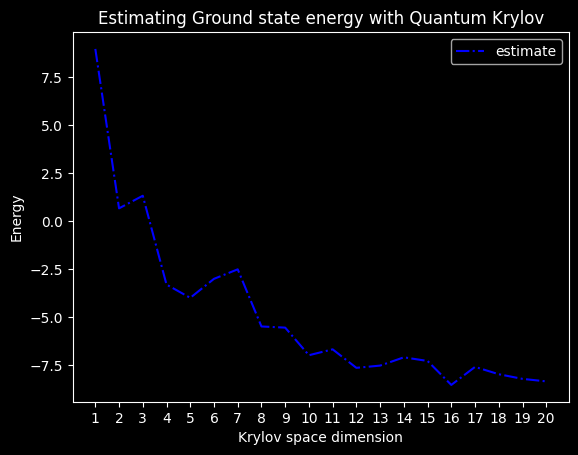

In [20]:
plt.plot(range(1, krylov_dim+1), gnd_en_circ_est_list, color = 'blue', linestyle='-.' , label = 'estimate')
plt.xticks(range(1, krylov_dim+1), range(1, krylov_dim+1))
plt.legend()
plt.xlabel('Krylov space dimension')
plt.ylabel('Energy')
plt.title('Estimating Ground state energy with Quantum Krylov')
plt.show()

In [21]:
np.min(np.linalg.eigh(H_op.to_matrix()).eigenvalues)

-9.000000000000009

### Take home exercise:
Compute ground state energy with other methods